# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [15]:
from helpers import get_dump_fnames, get_dumps, organize_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

# Find the relevant dumps
names = get_dump_fnames(PROTOCOLS, N)
dumps = get_dumps(names)

# Fetch relevant columns and rename them
df, ids = organize_dumps(dumps)

In [16]:
df

,Protocol,Batch ID,Stored Packets,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,32,False,2015-10-14 16:08:14,536870912,537766353,1297747,539064100,100.4,26.5,20308397.0
1,ftp,24,False,2015-10-14 16:48:49,536870912,537880833,1302499,539183332,100.4,25.7,20945515.3
2,ftp,3,False,2015-10-14 17:29:01,536870912,538012185,1309675,539321860,100.5,28.0,19194155.7
3,ftp,0,False,2015-10-14 16:11:01,1073741824,1045295361,2471835,1047767196,97.6,51.8,20167766.9
4,ftp,26,False,2015-10-14 16:51:28,1073741824,1069852313,2518315,1072370628,99.9,46.8,22874755.5
5,ftp,14,False,2015-10-14 17:31:42,1073741824,1076114033,2522163,1078636196,100.5,51.5,20887306.5
6,ftp,33,False,2015-10-14 16:16:02,1610612736,1614270641,3755019,1618025660,100.5,73.1,22086067.1
7,ftp,35,False,2015-10-14 16:56:11,1610612736,1613782721,3758211,1617540932,100.4,73.2,22049224.2
8,ftp,25,False,2015-10-14 17:36:33,1610612736,1613601625,3797843,1617399468,100.4,74.9,21534787.5
9,ftp,12,False,2015-10-14 16:23:22,2147479552,2152081841,4985379,2157067220,100.5,98.1,21935397.4


## Remove outliers
The data doesn't tend to have outliers for large filesizes, but with file less than 10Mb there can be some anomalies

In [17]:
sel = df[df["File Size (bytes)"] < 10000000] # Choose everything less than 10Mb
# If the ratio of filesize to packets is more than 1 million, there is a problem
outliers = sel[sel["Bytes Total"]/sel["File Size (bytes)"] > 1000000]

# Remove only those lines. For now, leave the rest of the batch
df.drop(outliers.index, inplace=True)

## Aggregate Data
The table above can be aggregated per filesize and protocol, then displayed visually.

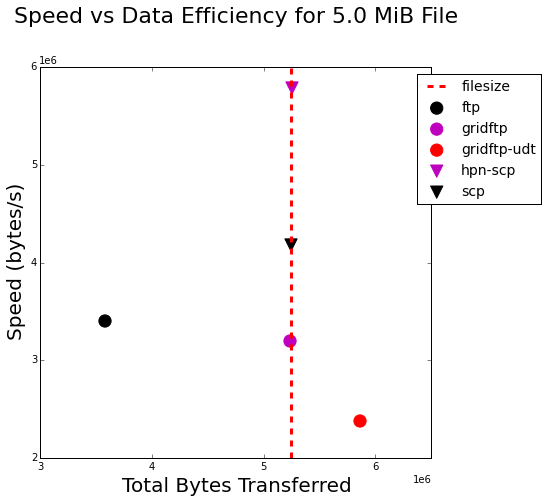

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed
import numpy as np
import pandas as pd

from plot import plot_speed_efficiency
from helpers import sizeof_fmt

rcParams['figure.figsize'] = (7, 7)

# Group by Filesize and then Protocol
agg = df.groupby(["File Size (bytes)", "Protocol"]).aggregate(np.mean)
agg.drop(["Batch ID", "Stored Packets"], axis=1, inplace=True)

sizes = {str(sizeof_fmt(x)):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(agg), filesize=sizes)

In [19]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# print agg.reset_index().to_latex()
agg

Bytes Down  Bytes Up  Bytes Total  Ratio (%)  \
File Size (bytes) Protocol                                                     
6                 ftp               2569.0   11880.3      14449.3   240822.2   
                  gridftp           3293.0   22625.2      25918.2   431970.8   
                  gridftp-udt       3285.8   19451.4      22737.2   378953.3   
                  hpn-scp           1693.0    2934.2       4627.2    77120.0   
                  scp               1825.0    3212.6       5037.6    83960.0   
5242880           ftp            3567737.0   12595.0    3580332.0       68.3   
                  gridftp        5234985.0    4440.3    5239425.3       99.9   
                  gridftp-udt    5855067.7    6452.3    5861520.0      111.8   
                  hpn-scp        5244154.3    8905.3    5253059.7      100.2   
                  scp            5242025.0    5973.0    5247998.0      100.1   
366448122         ftp          355460026.6  869439.8  356329466.4       97.2   
                  gridftp      365214569.4    4491.0  365219060.4       99.7   
                  gridftp-udt  373077927.4  120205.4  373198132.8      101.8   
                  hpn-scp      366891566.6  116639.0  367008205.6      100.2   
                  scp          366804940.2  130643.0  366935583.2      100.1   
536870912         ftp          537886457.0 1303307.0  539189764.0      100.4   
                  gridftp      536875497.0    4491.0  536879988.0      100.0   
                  gridftp-udt  556146935.7  177901.7  556324837.3      103.6   
                  hpn-scp      537531478.3  177159.0  537708637.3      100.2   
                  scp          537720193.0  197469.7  537917662.7      100.2   
1073741824        ftp         1063753902.3 2504104.3 1066258006.7       99.3   
                  gridftp     1066173841.0    4491.0 1066178332.0       99.3   
                  gridftp-udt 1112580553.0  341363.0 1112921916.0      103.6   
                  hpn-scp     1073680053.0  349815.0 1074029868.0      100.0   
                  scp         1075447142.3  395763.0 1075842905.3      100.2   
1535115264        ftp         1529632423.4 3596729.4 1533229152.8       99.9   
                  gridftp     1532645988.2    4491.0 1532650479.2       99.8   
                  gridftp-udt 1593804982.6  490088.6 1594295071.2      103.9   
                  hpn-scp     1515602696.2  497436.6 1516100132.8       98.8   
                  scp         1537618930.6  565835.0 1538184765.6      100.2   
1610612736        ftp         1613884995.7 3770357.7 1617655353.3      100.4   
                  gridftp     1610616827.7    4491.0 1610621318.7      100.0   
                  gridftp-udt 1668748709.0  509389.7 1669258098.7      103.6   
                  hpn-scp     1611559237.0  530859.0 1612090096.0      100.1   
                  scp         1613054875.7  589683.0 1613644558.7      100.2   
2147479552        ftp         2152091475.7 4992048.3 2157083524.0      100.4   
                  gridftp     2147483649.0    4491.0 2147488140.0      100.0   
                  gridftp-udt 2221995854.3  683089.7 2222678944.0      103.5   
                  hpn-scp     2143172293.0  704655.0 2143876948.0       99.8   
                  scp         2148225558.3  799896.3 2149025454.7      100.1   
2540610608        ftp         2542702419.0 5995699.0 2548698118.0      100.3   
                  gridftp     2540305805.0    4491.0 2540310296.0      100.0   
                  gridftp-udt 2641588171.5  809935.5 2642398107.0      104.0   
                  hpn-scp     2530431704.0  834031.5 2531265735.5       99.6   
                  scp         2518095638.0  924868.0 2519020506.0       99.2   

                               Time (s)  Speed (bytes/s)  
File Size (bytes) Protocol                                
6                 ftp               1.2           2120.2  
                  gridftp           1.2           2822.4  
                  gridftp-udt      

## Metrics per filesize
The above data can also be shown as two separate graphs, as a function of filesize.

## Speed

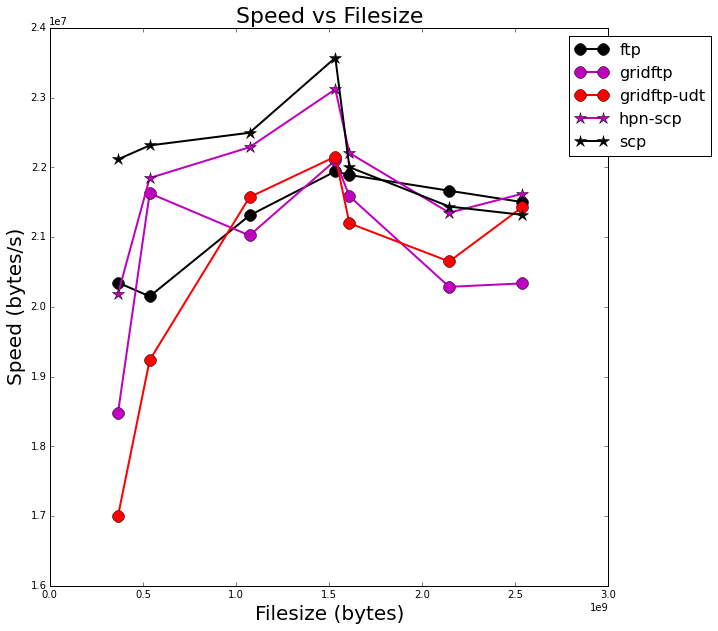

In [20]:
%matplotlib inline
from plot import plot_speed_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_speed_per_filesize(df, ratio=False, ignore_small=True)

## Data Usage

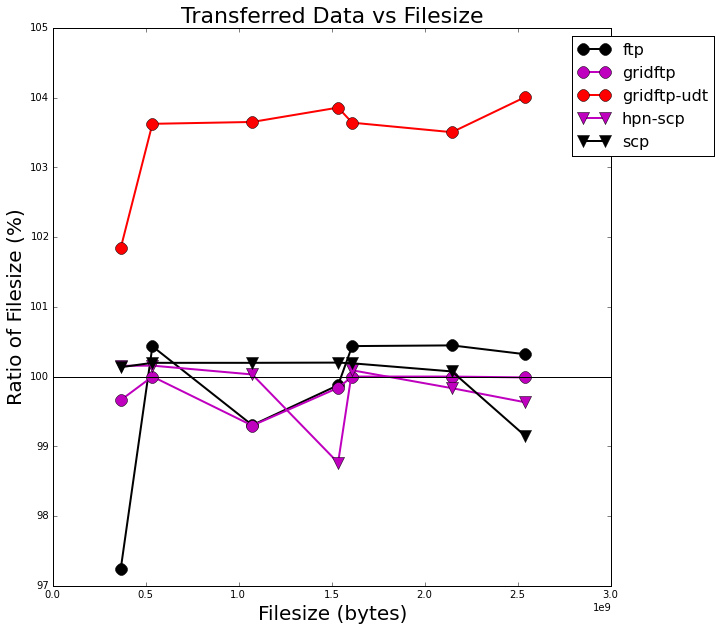

In [21]:
%matplotlib inline
from plot import plot_data_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_data_per_filesize(df, ignore_small=True)

## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

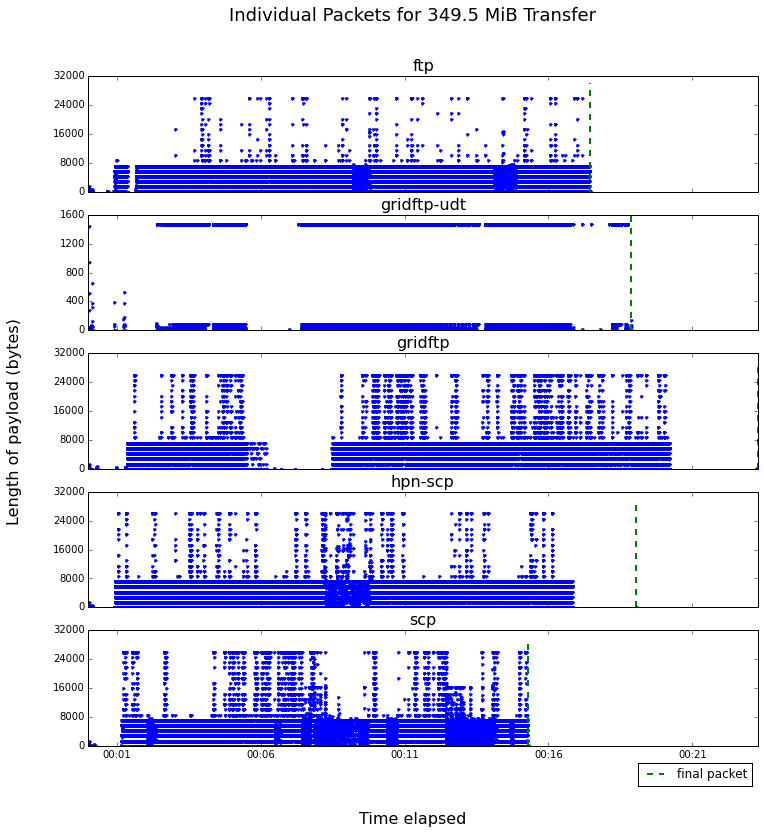

In [22]:
%matplotlib inline
import warnings

from plot import plot_packets

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

def reverse_lookup(bid):
    for key, val in ids.items():
        if val == bid:
            return key
    return None

batch_ids = {str(x):reverse_lookup(x) for x in set(df[df["Stored Packets"]]["Batch ID"])}

if batch_ids:
    packet_interact = interact(plot_packets, batch_id=batch_ids)
else:
    print "No batches with stored packets found"
    print "Run test.py with the --store-packets argument"